# Plot end of century precipitation

In [1]:
# Import functions
import warnings 
warnings.filterwarnings('ignore')
import os
import iris
import iris.cube
import cf_units
import numpy as np
import numpy.ma as ma
import xarray as xr
from scipy import stats
import regionmask
import iris.plot as iplt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_cm
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec

ERROR 1: PROJ: proj_create_from_database: Open of /home/h05/awells/.conda/envs/env/share/proj failed


## Load and process precip data

In [2]:
# file path
path = '/data/users/awells/geoMIP/processed_data/UKESM1_Annual_precip_full_'

ssp245 = xr.open_dataarray(path + 'ssp245_2020-2100.nc')
ssp585 = xr.open_dataarray(path + 'ssp585_2020-2100.nc')
g6con = xr.open_dataarray(path + 'G6controller_2020-2100.nc')
g6sulf = xr.open_dataarray(path + 'G6sulfur_2020-2100.nc')

Calculate end of century average and ensemble mean

In [3]:
ssp245_eoc = ssp245.sel(time=slice('2081','2101')).mean(dim=('time', 'realization'))
ssp245_eoc_std = ssp245.sel(time=slice('2081','2101')).std('time').mean('realization')
ssp585_eoc = ssp585.sel(time=slice('2081','2101')).mean(dim=('time', 'realization'))
g6con_eoc = g6con.sel(time=slice('2081','2101')).mean(dim=('time', 'realization'))
g6sulf_eoc = g6sulf.sel(time=slice('2081','2101')).mean(dim=('time', 'realization'))

Convert longitude 

In [4]:
def adjust_longitude(dataset: xr.Dataset) -> xr.Dataset:
        """Swaps longitude coordinates from range (0, 360) to (-180, 180)
        Args:
            dataset (xr.Dataset): xarray Dataset
        Returns:
            xr.Dataset: xarray Dataset with swapped longitude dimensions
        """
        lon_name = "longitude"  # whatever name is in the data

        # Adjust lon values to make sure they are within (-180, 180)
        dataset["_longitude_adjusted"] = xr.where(
            dataset[lon_name] > 180, dataset[lon_name] - 360, dataset[lon_name])
        dataset = (
            dataset.swap_dims({lon_name: "_longitude_adjusted"})
            .sel(**{"_longitude_adjusted": sorted(dataset._longitude_adjusted)})
            .drop(lon_name)
        )

        dataset = dataset.rename({"_longitude_adjusted": lon_name})
        return dataset

ssp245_mean = adjust_longitude(ssp245_eoc)
ssp245_std = adjust_longitude(ssp245_eoc_std)
ssp585_mean = adjust_longitude(ssp585_eoc)
g6con_mean = adjust_longitude(g6con_eoc)
g6sulf_mean = adjust_longitude(g6sulf_eoc)

Percentage difference

In [5]:
ssp585_perc = ((ssp585_mean - ssp245_mean)/ssp245_mean)*100
g6sulf_perc = ((g6sulf_mean - ssp245_mean)/ssp245_mean)*100
g6con_perc = ((g6con_mean - ssp245_mean)/ssp245_mean)*100

Remove ocean

In [6]:
landfrac = iris.load_cube('/home/h05/awells/geoMIP/plotting/land_fraction.pp')
lf = adjust_longitude(xr.DataArray.from_iris(landfrac))

ssp245_land = ssp245_mean.where(lf >= 0.5)
ssp245_std_land = ssp245_std.where(lf >= 0.5)
ssp585_land = ssp585_mean.where(lf >= 0.5)
g6con_land = g6con_mean.where(lf >= 0.5)
g6sulf_land = g6sulf_mean.where(lf >= 0.5)

## Calculate statistical significance

In [7]:
ssp245_r = ssp245.sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(ssp245.realization)):
    ssp245_r = xr.concat((ssp245_r, ssp245.sel(time=slice('2081','2101')).sel(realization=i)), dim='time')

ssp585_r = ssp585.sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(ssp585.realization)):
    ssp585_r = xr.concat((ssp585_r, ssp585.sel(time=slice('2081','2101')).sel(realization=i)), dim='time')
    
g6sulf_r = g6sulf.sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(g6sulf.realization)):
    g6sulf_r = xr.concat((g6sulf_r, g6sulf.sel(time=slice('2081','2101')).sel(realization=i)), dim='time')
    
g6con_r = g6con.sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(g6con.realization)):
    g6con_r = xr.concat((g6con_r, g6con.sel(time=slice('2081','2101')).sel(realization=i)), dim='time')

In [8]:
stat, pval = stats.ttest_ind(ssp585_r, ssp245_r)
pval_ssp585 = adjust_longitude(xr.DataArray(data=pval, 
                     dims=['latitude', 'longitude'], 
                     coords=dict(longitude=(['longitude'], ssp245_r.longitude.values), 
                                 latitude=(['latitude'], ssp245_r.latitude.values))))

stat, pval = stats.ttest_ind(g6sulf_r, ssp245_r)
pval_g6sulf = adjust_longitude(xr.DataArray(data=pval, 
                     dims=['latitude', 'longitude'], 
                     coords=dict(longitude=(['longitude'], ssp245_r.longitude.values), 
                                 latitude=(['latitude'], ssp245_r.latitude.values))))

stat, pval = stats.ttest_ind(g6con_r, ssp245_r)
pval_g6con = adjust_longitude(xr.DataArray(data=pval, 
                     dims=['latitude', 'longitude'], 
                     coords=dict(longitude=(['longitude'], ssp245_r.longitude.values), 
                                 latitude=(['latitude'], ssp245_r.latitude.values))))

## Calculate regional precipitation

In [9]:
ar6_land = regionmask.defined_regions.ar6.land
mask_3D = ar6_land.mask_3D(ssp245_mean.longitude, ssp245_mean.latitude)

In [10]:
weights = np.cos(np.deg2rad(ssp245_mean.latitude))
ssp245_regional = ssp245_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
ssp245_std_regional = ssp245_std_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
ssp585_regional = ssp585_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
g6sulf_regional = g6sulf_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
g6con_regional = g6con_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))

In [11]:
ssp585_miss = np.where(np.logical_or((ssp585_regional - ssp245_regional) > ssp245_std_regional, (ssp585_regional - ssp245_regional) < -ssp245_std_regional))[0]
g6sulf_miss = np.where(np.logical_or((g6sulf_regional - ssp245_regional) > ssp245_std_regional, (g6sulf_regional - ssp245_regional) < -ssp245_std_regional))[0]
g6con_miss = np.where(np.logical_or((g6con_regional - ssp245_regional) > ssp245_std_regional, (g6con_regional - ssp245_regional) < -ssp245_std_regional))[0]

ssp585_regions = ar6_land[ssp585_miss.tolist()]
g6sulf_regions = ar6_land[g6sulf_miss.tolist()]
g6con_regions = ar6_land[g6con_miss.tolist()]

Global mean precip

In [12]:
weights = np.cos(np.deg2rad(ssp245.latitude))
weights.name = "weights"

ssp245_gmean = ssp245.weighted(weights).mean(('longitude', 'latitude'))
ssp585_gmean = ssp585.weighted(weights).mean(('longitude', 'latitude'))
g6con_gmean = g6con.weighted(weights).mean(('longitude', 'latitude'))
g6sulf_gmean = g6sulf.weighted(weights).mean(('longitude', 'latitude'))

## Plotting

In [14]:
params = {'legend.fontsize': 20,
          'axes.labelsize': 30,
          'axes.titlesize': 30,
          'axes.linewidth': 8,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'axes.grid': True}

plt.rcParams.update(params)

def autosize_figure(nrows, ncolumns, scale_factor=1, xscale_factor=1, yscale_factor=1):
    xwidth = (ncolumns+0.67) * 5.0 * scale_factor * xscale_factor
    ylength = (nrows+0.67) * 3.6 * scale_factor * yscale_factor
    return (xwidth, ylength)

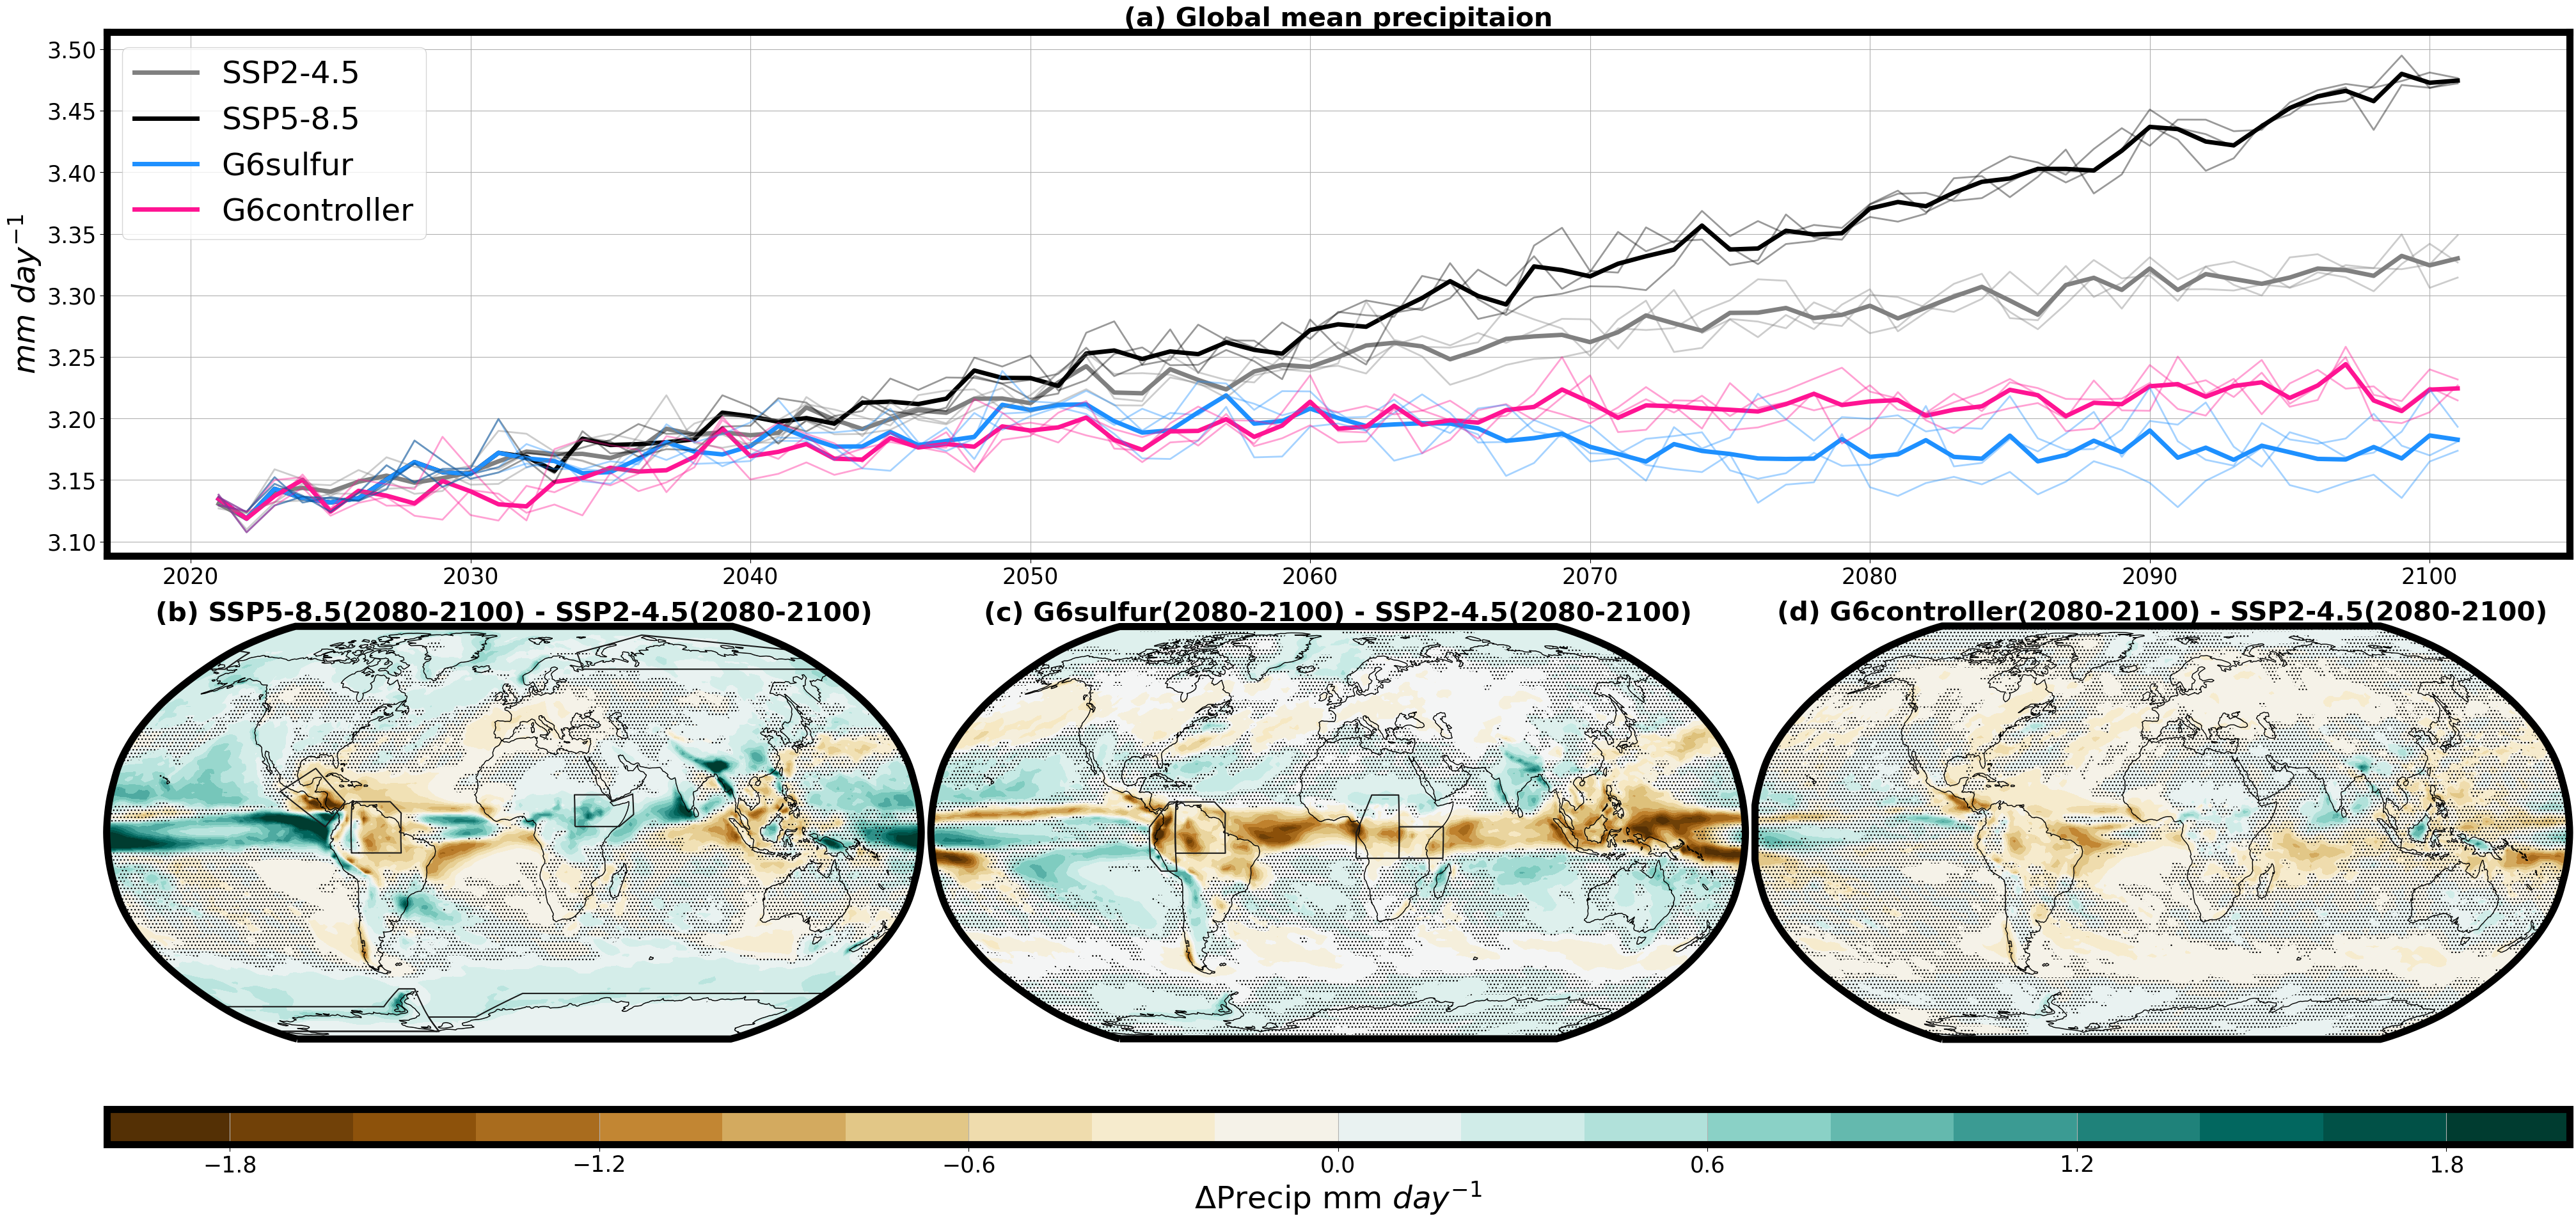

In [15]:
col_map = mpl_cm.get_cmap('BrBG')
projection = ccrs.Robinson()
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=autosize_figure(2, 3, scale_factor=2, xscale_factor=1.1))
gs = GridSpec(3, 3, height_ratios=[15, 15, 1])

lvs = np.linspace(-2, 2, 21)

ax0 = fig.add_subplot(gs[0,:])
ax0.grid(True)
ssp245_gmean.mean('realization').plot(color='grey', linewidth=5, label='SSP2-4.5')
ssp585_gmean.mean('realization').plot(color='k', linewidth=5, label='SSP5-8.5')
g6sulf_gmean.mean('realization').plot(color='dodgerblue', linewidth=5, label='G6sulfur')
g6con_gmean.mean('realization').plot(color='deeppink', linewidth=5, label='G6controller')

for i in range(3):
    ssp245_gmean.sel(realization=i).plot(color='grey', linewidth=2, alpha=0.4)
    ssp585_gmean.sel(realization=i).plot(color='k', linewidth=2, alpha=0.4)
    g6sulf_gmean.sel(realization=i).plot(color='dodgerblue', linewidth=2, alpha=0.4)
    g6con_gmean.sel(realization=i).plot(color='deeppink', linewidth=2, alpha=0.4)

plt.title('(a) Global mean precipitaion', fontweight='bold')
plt.xlabel('')
plt.ylabel('$mm$ $day^{-1}$', fontsize=35)
plt.legend(fontsize=35)

ax1 = fig.add_subplot(gs[1, 0], projection=projection, frameon=True)
(ssp585_mean - ssp245_mean).plot.contourf(transform=crs, cmap=col_map, levels=lvs, add_colorbar=False, subplot_kws={'projection':projection})
pval_ssp585.where(pval_ssp585>0.05).plot.contourf(transform=crs, colors='none', levels=[0,1], hatches=['...'], add_colorbar=False, subplot_kws={'projection':projection})
if np.any(ssp585_regions) != False:
    ssp585_regions.plot(add_label=False)
ax1.coastlines()
plt.title('(b) SSP5-8.5(2080-2100) - SSP2-4.5(2080-2100)', fontweight='bold')

ax2 = fig.add_subplot(gs[1, 1], projection=projection, frameon=True)
(g6sulf_mean - ssp245_mean).plot.contourf(transform=crs, cmap=col_map, levels=lvs, add_colorbar=False, subplot_kws={'projection':projection})
pval_g6sulf.where(pval_g6sulf>0.05).plot.contourf(transform=crs, colors='none', levels=[0,1], hatches=['...'], add_colorbar=False, subplot_kws={'projection':projection})
if np.any(g6sulf_regions) != False:
    g6sulf_regions.plot(add_label=False)
ax2.coastlines()
plt.title('(c) G6sulfur(2080-2100) - SSP2-4.5(2080-2100)', fontweight='bold')

ax3 = fig.add_subplot(gs[1, 2], projection=projection, frameon=True)
cb = (g6con_mean - ssp245_mean).plot.contourf(transform=crs, cmap=col_map, levels=lvs, add_colorbar=False, subplot_kws={'projection':projection})
pval_g6con.where(pval_g6con>0.05).plot.contourf(transform=crs, colors='none', levels=[0,1], hatches=['...'], add_colorbar=False, subplot_kws={'projection':projection})
if np.any(g6con_regions) != False:
    g6con_regions.plot(add_label=False)
ax3.coastlines()
plt.title('(d) G6controller(2080-2100) - SSP2-4.5(2080-2100)', fontweight='bold')

cax1 = fig.add_subplot(gs[2, :])
col_bar = plt.colorbar(cb, cax=cax1, orientation='horizontal')
col_bar.set_label('$\Delta$Precip mm $day^{-1}$', fontsize=35)

plt.tight_layout()
plt.savefig('/net/home/h05/awells/PycharmProjects/G6_comparison/Plots/Wells2023/Figure6.png', dpi=200)
plt.show()